comes from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# prepare data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [5]:
dataset = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv',parse_dates=[['year','month'
                                                                       ,'day','hour']],
                     index_col =0, date_parser = parse)

In [6]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
dataset.drop('No',axis = 1, inplace = True)

In [8]:
dataset.columns = ['pol','dew','temp','press','wnd_dir','wnd_spd','snow','rain']

In [9]:
dataset = dataset [24:]

In [10]:
dataset.index.name = 'date'

In [11]:
dataset.head()

,pol,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [12]:
# save to pollution.csv
dataset.to_csv('pollution.csv')

# plot data

In [13]:
# load csv
dataset = pd.read_csv('pollution.csv',header = 0, index_col = 0)

In [14]:
values = dataset.values

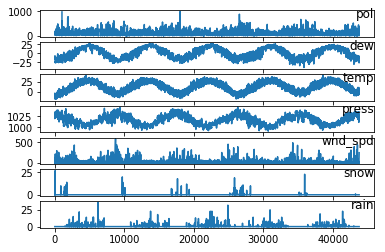

In [15]:
groups = [0,1,2,3,5,6,7]
i=1
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],y=0.5,loc = 'right')
    i +=1
plt.show()

# fit LSTM

In [16]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
values = dataset.values

In [17]:
values[1,:]

array([148.0, -15, -4.0, 1020.0, 'SE', 2.68, 0, 0], dtype=object)

In [18]:
lencod = LabelEncoder()
values[:,4] = lencod.fit_transform(values[:,4])

In [19]:
values = values.astype('float32')

In [20]:
## do onehot encoder

In [21]:
#normalize features
from sklearn.preprocessing import MinMaxScaler
values[np.isnan(values)] =0
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [23]:
reframed = series_to_supervised(scaled,1,1)

# define and fit model

In [24]:
values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]
# split into input and outputs
train_X, train_y = train[:,:-1],train[:,-1]
test_X, test_y = test[:,:-1],test[:,-1]
# reshape input to be 3d [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

train_X.shape,train_y.shape,test_X.shape,test_y.shape

((8760, 1, 15), (8760,), (35039, 1, 15), (35039,))

In [77]:
# design network
from keras.models import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50,input_shape = (train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam')

In [78]:
history = model.fit(train_X,train_y,epochs = 25, batch_size= 72, 
                   validation_data = (test_X,test_y),verbose=2,
                   shuffle = False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/25
2s - loss: 0.0134 - val_loss: 0.0079
Epoch 2/25
1s - loss: 0.0093 - val_loss: 0.0072
Epoch 3/25
1s - loss: 0.0087 - val_loss: 0.0078
Epoch 4/25
1s - loss: 0.0087 - val_loss: 0.0083
Epoch 5/25
1s - loss: 0.0078 - val_loss: 0.0082
Epoch 6/25
1s - loss: 0.0083 - val_loss: 0.0058
Epoch 7/25
1s - loss: 0.0079 - val_loss: 0.0103
Epoch 8/25
1s - loss: 0.0083 - val_loss: 0.0061
Epoch 9/25
1s - loss: 0.0075 - val_loss: 0.0056
Epoch 10/25
1s - loss: 0.0061 - val_loss: 0.0051
Epoch 11/25
1s - loss: 0.0062 - val_loss: 0.0050
Epoch 12/25
1s - loss: 0.0065 - val_loss: 0.0048
Epoch 13/25
1s - loss: 0.0061 - val_loss: 0.0048
Epoch 14/25
1s - loss: 0.0061 - val_loss: 0.0046
Epoch 15/25
1s - loss: 0.0056 - val_loss: 0.0038
Epoch 16/25
1s - loss: 0.0049 - val_loss: 0.0041
Epoch 17/25
1s - loss: 0.0040 - val_loss: 0.0038
Epoch 18/25
1s - loss: 0.0044 - val_loss: 0.0056
Epoch 19/25
1s - loss: 0.0043 - val_loss: 0.0044
Epoch 20/25
1s - loss: 0.0046

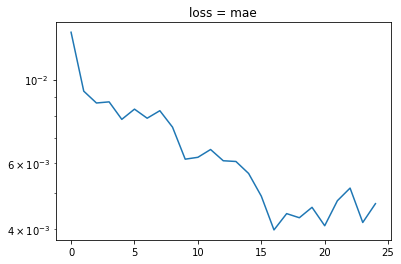

In [80]:
# plot history
%matplotlib inline
plt.semilogy(history.history['loss'])
plt.title('loss = mae')

In [30]:
history

In [68]:
#make prediction.
yhat = model.predict(test_X)


In [69]:
yhat.shape

(35039, 1)

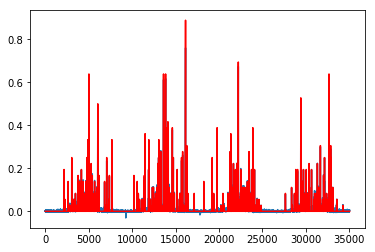

In [70]:
test_y_ap = np.append(0,test_y)
plt.plot(yhat)
plt.plot(test_y_ap,'r')
#plt.xlim(2100,2200)

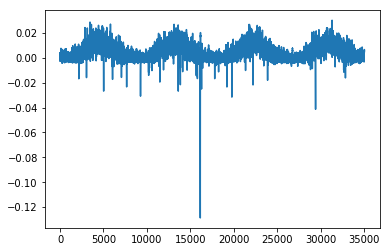

In [71]:
error_y = np.reshape(yhat,-1)-test_y_ap[:-1]
plt.plot(error_y)


In [35]:
error_y

(35039,)

In [50]:
test_y_ap.shape

(35040,)